# Stimulative Image Generation

---

**Interpretability of MLP Layers in Vision Transformers**


**Created by:** Mika Allert

<br>

## Table of Contents

---

- [1 Introduction](#1-Introduction)
- [2 Prerequisites](#2-Prerequisites)
- [3 Objective](#3-Objective)
- [4 Generating Images](#4-Generating-an-Image)
- [5 Evaluating Images](#5-Evaluating-Images)

## Getting Started

Before starting with the coding section of the notebook, it is necessary to import a few packages, as well setup appropriate extension parameters.

__NOTE__: To make sure that all the imports in this notebook work properly, make sure the Conda environment is setup correctly and this here package is installed locally.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from timm import create_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

<br>

# 1 Introduction

---

[Lucid](https://github.com/tensorflow/lucid) is a Tensorflow library for neural network interpretability, or in other words a feature visualization library for convolutional neural networks (CNNs). We will be using [Lucent](https://github.com/greentfrapp/lucent), which is a PyTorch implementation of the corresponding Tensorflow library. More specifically, we will use [a fork of this library](https://github.com/SoulofAkuma/lucent-cluster), created for this project, that adds support for execution on a specific device, which is crucial in a cluster environment. All files necessary to generate images for all ImageNet-1k classes for any Vision Transformer on a SLURM cluster, can be found under `jobs/lucent`.

Lucid is able to generate feature maximizing images specifically for CNNs. However, because the Lucent implementation is written in a very functional manner, it is possible to hijack the objective lucent optimizes for and introduce a new one that optimizes for a key-value vector neuron pair in a Transformer. Equally we can introduce a new diversity objective function, that calculates the covariance matrix among corresponding patches in an image batch and optimizes for greater distance between the images, by optimizing to reduce the sum of said covariances. For more information on key-value vector and background on the approach, please refer to the final project report.

The reason why Lucid/Lucent is used here and there isn't a self-written optimization, is that there are some caveats with naively optimizing with the neuron-pair and diversity gradient. The output is often quite noisy and not very robust to transformations in the image. To counteract this problem, Lucid introduces a Fourier transform frequency reduction in the gradient, as well as jitter, scaling, rotation transformations to the image being optimized. The creators of Lucid have written a more detailed article on this topic, which can be found [here](https://distill.pub/2017/feature-visualization/).

<br>

# 2 Prerequisites

---

All of the logic to interact with Lucent, has already been implemented within this project. All interaction with lucent directly, is just to demonstrate what the underlying functions do. As a first step, it is necessary to create a model to use for the image generation. In the following we will create such a model (feel free to change adjust the model here). We will use `vit_base_patch16_224`, meaning a Vision Transformer with image patches of $16 \times 16$ resolution and an image resolution of $224 \times 224$ pixels, to reduce the computational cost. It is encouraged to also try out `vit_base_patch16_384` to generate higher resolution images. The model parameters are frozen throughout the whole notebook, because optimization is conducted with respect to the input and not the model parameters, which are the subject of interpretation. 

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

TIMM_MODEL_DESCRIPTOR = 'vit_base_patch16_224'
model = create_model(TIMM_MODEL_DESCRIPTOR, pretrained=True)

model = model.to(device).eval()

print(f'Executing calculations on {device}')

Executing calculations on cuda


Later on, in the [evaluation section](#5-Evaluating-Images), we expect computed images for all ImageNet-1k classes. While it is always possible to generate these images with the provided SLURM scripts on a cluster or locally, precomputed images are provided in resolution $128 \times 128$ pixels and $384 \times 384$ pixels [here](https://drive.google.com/drive/folders/1a5jmo5I-SpNSc7nby-9QsJrgruYGApU4?usp=sharing). The images in the higher resolution are available pre- and post-activation function of the hidden layer between the key and value neurons, while the images in lower resolution are only available pre-activation.

Generally, optimizing pre-activation leads to significantly better results on average, while optimizing post-activation may, depending on the seed, lead to great or meaningless visual results. In the following, we define the path to the local images and create the dataset. Note that the dataset offers the flexibility to use a subset of available iterations and generation types (`clear` for optimizing for the top key neuron only and `div` for optimizing for the key neuron as well as batch diversity). For our evaluation, it is sufficient to use the clear images only, at their last iteration.

__NOTE__: If you want to generate the images on a SLURM Cluster yourself, make sure to adjust and use the `scripts/prepare_predictive_images.py` script on the generated image folder.

In [3]:
from src.datasets.MostPredictiveImages import MostPredictiveImagesDataset

LUCENT_IMAGES_PATH = 'A:\CVData\project-images\images-128-fc1' # Put your path in here

lucent_images_dataset = MostPredictiveImagesDataset(LUCENT_IMAGES_PATH, 'clear', {750})

In addition to this data, it is also helpful to define a few classes that have shown to produce good looking results and some are less interpretable.

In [4]:
from src.utils.imagenet import get_imagenet_id_for_names, get_index_for_imagenet_id
from typing import List, Dict, Tuple

good_classes = ['brown_bear', 'binoculars', 'candle', 
                'cassette_player', 'tiger', 'pirate']
good_class_mapping: Dict[str, Tuple[str, int]] = {
    name: (cls, get_index_for_imagenet_id(cls)) 
    for name, cls in zip(good_classes, get_imagenet_id_for_names(good_classes))
}

bad_classes = ['Rhodesian_ridgeback', 'flat-coated_retriever', 'Boston_bull',
               'dishrag', 'feather_boa', 'fountain']
bad_class_mapping: Dict[str, Tuple[str, int]] = {
    name: (cls, get_index_for_imagenet_id(cls)) # tuple of imagenet id and index
    for name, cls in zip(bad_classes, get_imagenet_id_for_names(bad_classes))
}

<br>

# 3 Objective

---

Simply put, the objective is the loss function Lucent will be optimizing the image for. Lucent comes with some pre-implemented objectives, among them ones to optimize the input with respect to channels, CNN neurons and many more. As these objectives are mostly built for working with CNNs, we offer a new implementation for Transformer MLP key neuron activation maximization, as well as another one for diversity within an image batch, to pull apart the individual images. 

If the hypothesis to verify is, that the classification for a certain class is mostly expressed through specific value vectors, the objective would be to optimize for the activation of the corresponding key vectors. The simplest case is to optimize for the key vector activation of the most predictive value vector for a class, meaning the value vector with the highest probability for a given class, when projected into the embedding space. 

To achieve that, we will extract the value vectors for the model, project them into the class embedding space and retrieve the index of the most predictive value vector. This index can then be used to generate the desired objective.

In [5]:
from src.utils.extraction import extract_value_vectors
from src.utils.model import embedding_projection
from src.analyzers.mlp_value_analyzer import most_predictive_ind_for_class
from src.visualizers.lucent import key_neuron_objective, transformer_diversity_objective

VISUALIZE_PRE_ACTIVATION = True
DIVERSITY_WEIGHT = 1e-2

# Extract values, project vectors and determine top value vector index
value_vectors = extract_value_vectors(model, device)
projected_values = embedding_projection(model, value_vectors, device)
most_predictive_value_indices = most_predictive_ind_for_class(projected_values, device)

# Generate key neuron objectives for all good and bad classes
key_neuron_objective_for_cls = lambda cls_ind: key_neuron_objective(
    most_predictive_value_indices[0, cls_ind],
    most_predictive_value_indices[1, cls_ind],
    before_nonlinear=VISUALIZE_PRE_ACTIVATION
)
diversity_objective_for_cls = lambda cls_ind: transformer_diversity_objective(
    most_predictive_value_indices[0, cls_ind],
    before_nonlinear=VISUALIZE_PRE_ACTIVATION
)

good_classes_top_value_objective = {
    name: key_neuron_objective_for_cls(idx)
    for name, (id, idx) in good_class_mapping.items() 
}

bad_classes_top_value_objective = {
    name: key_neuron_objective_for_cls(idx)
    for name, (id, idx) in bad_class_mapping.items()
}

good_classes_top_div_value_objective = {
    name: key_neuron_objective_for_cls(idx) - DIVERSITY_WEIGHT * diversity_objective_for_cls(idx)
    for name, (id, idx) in good_class_mapping.items() 
}

bad_classes_top_div_value_objective = {
    name: key_neuron_objective_for_cls(idx) - DIVERSITY_WEIGHT * diversity_objective_for_cls(idx)
    for name, (id, idx) in bad_class_mapping.items()
}

As can be seen above, the objectives can be used in mathematical expression to weight and mix them. We will utilize this later, to build objectives optimizing for multiple value vectors at once. As the implementation for this is a little more complex, it will not be showcased in this notebook, but feel free to take a look at the implementation in the source code of this project. However, when mixing the objectives the question arises how each contributing value vector should be weighted. There are 3 pre-implemented weighting schemes that you can try out which are:

1. `equal` - meaning all $k$ value vectors are weighed with $\frac{1}{k}$.
2. `score` - meaning every value vector is weighted by the softmax probability for the target class, normalized with the sum over all probabilities.
3. `softmax_score` - meaning the probabilities of each value vector for the target class are collected and each of the value vectors is then weighted with respect to the softmax of these probabilities.

We will use the default `softmax_score` schema, but as mentioned above, you can adjust that in the [Generating Images](#4-Generating-Images) section.

<br>

# 4 Generating Images

---

Now that we have the necessary objectives, we will generate images for a split of the good and bad classes with this method. The other split will be generated with the pre-implemented method in the project code that will take care of all of the above for us. Note that the `ITERATIONS` parameter here defines at which iteration count Lucent will save a version of the image. So in its current state, we actually get $3$ images for every non diversity objective and $|\text{iterations}| \cdot \text{batchsize} = 3 \cdot 3 = 9$ images for every diversity objective.

In [6]:
from lucent.optvis.render import render_vis
from lucent.optvis import param
from src.visualizers.lucent import image_batch

SPLIT_BOUNDARY = 2
IMAGE_SIZE = 128
MODEL_IMAGE_SIZE = 224
DIVERSITY_BATCH_SIZE = 3
ITERATIONS = [167, 334, 500]

good_images_single_value = {}
good_images_single_value_div = {}

bad_images_single_value = {}
bad_images_single_value_div = {}

for i in range(SPLIT_BOUNDARY):
    cls = good_classes[i]

    image = lambda: param.image(IMAGE_SIZE, device=device)
    img_batch = image_batch(IMAGE_SIZE, DIVERSITY_BATCH_SIZE, device=device)

    good_images_single_value[cls] = render_vis(model, good_classes_top_value_objective[cls],
                                               image, show_inline=False, show_image=False,
                                               thresholds=ITERATIONS,
                                               fixed_image_size=MODEL_IMAGE_SIZE,
                                               device=device)
    good_images_single_value_div[cls] = render_vis(model, 
                                                   good_classes_top_div_value_objective[cls],
                                                   img_batch, thresholds=ITERATIONS,
                                                   show_inline=False, show_image=False,
                                                   fixed_image_size=MODEL_IMAGE_SIZE,
                                                   device=device)
    
    cls = bad_classes[i]

    image = lambda: param.image(IMAGE_SIZE, device=device)
    img_batch = image_batch(IMAGE_SIZE, DIVERSITY_BATCH_SIZE, device=device)

    bad_images_single_value[cls] = render_vis(model, bad_classes_top_value_objective[cls],
                                              image, show_inline=False, show_image=False,
                                              thresholds=ITERATIONS,
                                              fixed_image_size=MODEL_IMAGE_SIZE,
                                              device=device)
    bad_images_single_value_div[cls] = render_vis(model, 
                                                  bad_classes_top_div_value_objective[cls],
                                                  img_batch, thresholds=ITERATIONS,
                                                  show_inline=False, show_image=False,
                                                  fixed_image_size=MODEL_IMAGE_SIZE,
                                                  device=device)


100%|██████████| 500/500 [00:29<00:00, 17.16it/s]


As can be seen by the above, the overhead to generate these images is quite large. Utilizing the pre-implemented method for the rest of the classes, we are able to reduce the lines of code we have to write significantly. Note that we pass the `most_predictive_inds` to avoid recomputing this for every function call.

In [12]:
from src.visualizers.lucent import generate_most_stimulative_for_imgnet_id

for i in range(SPLIT_BOUNDARY, len(good_classes)):
    good_cls = good_classes[i]
    bad_cls = bad_classes[i]

    good_images_single_value[good_cls] = generate_most_stimulative_for_imgnet_id(
        model, good_class_mapping[good_cls][0], device=device, 
        most_predictive_inds=most_predictive_value_indices,
        img_size=IMAGE_SIZE, model_img_size=MODEL_IMAGE_SIZE, 
        keys_before_nonlinear=VISUALIZE_PRE_ACTIVATION, iterations=ITERATIONS
    )
    good_images_single_value_div[good_cls] = generate_most_stimulative_for_imgnet_id(
        model, good_class_mapping[good_cls][0], diversity=True, batchsize=DIVERSITY_BATCH_SIZE,
        device=device, most_predictive_inds=most_predictive_value_indices,
        iterations=ITERATIONS, div_weight=DIVERSITY_WEIGHT, img_size=IMAGE_SIZE, 
        model_img_size=MODEL_IMAGE_SIZE, keys_before_nonlinear=VISUALIZE_PRE_ACTIVATION
    )

    bad_images_single_value[bad_cls] = generate_most_stimulative_for_imgnet_id(
        model, bad_class_mapping[bad_cls][0], device=device, 
        most_predictive_inds=most_predictive_value_indices,
        img_size=IMAGE_SIZE, model_img_size=MODEL_IMAGE_SIZE, 
        keys_before_nonlinear=VISUALIZE_PRE_ACTIVATION, iterations=ITERATIONS
    )
    bad_images_single_value_div[bad_cls] = generate_most_stimulative_for_imgnet_id(
        model, bad_class_mapping[bad_cls][0], diversity=True, batchsize=DIVERSITY_BATCH_SIZE,
        device=device, most_predictive_inds=most_predictive_value_indices,
        iterations=ITERATIONS, div_weight=DIVERSITY_WEIGHT, img_size=IMAGE_SIZE, 
        model_img_size=MODEL_IMAGE_SIZE, keys_before_nonlinear=VISUALIZE_PRE_ACTIVATION
    )

100%|██████████| 500/500 [00:28<00:00, 17.39it/s]


To wrap things up, we will also generate images using mixed objectives that optimize for the top $k = 5$ value vectors for a class. There is also an implemented function in this project to achieve that, which works almost exactly the same as the one for the top value vector, except that you have to provide a the parameter $k$. Feel free to experiment with this parameter, but with the softmax weighting scheme, values higher than $5$ will not have a large influence on the optimization.  

In [14]:
from src.visualizers.lucent import weighting_schema
from src.visualizers.lucent import generate_mixed_most_stimulative_for_imgnet_id
from src.analyzers.mlp_value_analyzer import k_most_predictive_ind_for_class

K = 5
WEIGHTING_SCHEMA: weighting_schema = 'softmax_score'

good_images_multiple_values = {}
good_images_multiple_values_div = {}

bad_images_multiple_values = {}
bad_images_multiple_values_div = {}

k_most_predictive_inds = k_most_predictive_ind_for_class(projected_values, K, device=device)

for i in range(len(good_classes)):

    good_cls = good_classes[i]
    bad_cls = bad_classes[i]

    good_images_multiple_values[good_cls] = generate_mixed_most_stimulative_for_imgnet_id(
        model, good_class_mapping[good_cls][0], K, device=device, 
        projected_values=projected_values,
        k_most_predictive_inds=k_most_predictive_inds,
        img_size=IMAGE_SIZE, model_img_size=MODEL_IMAGE_SIZE, 
        keys_before_nonlinear=VISUALIZE_PRE_ACTIVATION, iterations=ITERATIONS,
        weighting_schema=WEIGHTING_SCHEMA
    )
    good_images_multiple_values_div[good_cls] = generate_mixed_most_stimulative_for_imgnet_id(
        model, good_class_mapping[good_cls][0], K, diversity=True, batchsize=DIVERSITY_BATCH_SIZE,
        device=device, k_most_predictive_inds=k_most_predictive_inds,
        projected_values=projected_values,
        iterations=ITERATIONS, div_weight=DIVERSITY_WEIGHT, img_size=IMAGE_SIZE, 
        model_img_size=MODEL_IMAGE_SIZE, keys_before_nonlinear=VISUALIZE_PRE_ACTIVATION,
        weighting_schema=WEIGHTING_SCHEMA
    )

    bad_images_multiple_values[bad_cls] = generate_mixed_most_stimulative_for_imgnet_id(
        model, bad_class_mapping[bad_cls][0], K, device=device, 
        k_most_predictive_inds=k_most_predictive_inds,
        projected_values=projected_values,
        img_size=IMAGE_SIZE, model_img_size=MODEL_IMAGE_SIZE, 
        keys_before_nonlinear=VISUALIZE_PRE_ACTIVATION, iterations=ITERATIONS,
        weighting_schema=WEIGHTING_SCHEMA
    )
    bad_images_multiple_values_div[bad_cls] = generate_mixed_most_stimulative_for_imgnet_id(
        model, bad_class_mapping[bad_cls][0], K, diversity=True, batchsize=DIVERSITY_BATCH_SIZE,
        device=device, k_most_predictive_inds=k_most_predictive_inds,
        projected_values=projected_values,
        iterations=ITERATIONS, div_weight=DIVERSITY_WEIGHT, img_size=IMAGE_SIZE, 
        model_img_size=MODEL_IMAGE_SIZE, keys_before_nonlinear=VISUALIZE_PRE_ACTIVATION,
        weighting_schema=WEIGHTING_SCHEMA
    )

100%|██████████| 500/500 [00:32<00:00, 15.16it/s]


<br>

# 5 Evaluating Results

---

### Quantitative Evaluation

We will be starting off with the evaluation that leaves a lot of space for future work, which is the quantitative evaluation of the results. For that, we will refer to the already generated images in our dataset and not the images generated here. There are two approaches that have been implemented here.
1. Determining the rate of correct prediction for all the generated images, so over all generated images, what is the rate that these images predict the classes they were tasked to maximize.
2. Determining the images, which were able to perform their task the best, meaning the ones that have optimized their single value maximization objective best.

Lets start by looking at 1 and use a pre-implemented function from the project to determine the result.

__NOTE__: We need the Huggingface Model Descriptor here, to get an image preparation pipeline for the transformer model we are using. Do not forget to adjust this value, if you've changed out the Transformer model above.

In [16]:
from src.analyzers.lucent_analyzer import correct_prediction_rate

HUGGINGFACE_MODEL_DESCRIPTOR = 'google/vit-base-patch16-224-in21k'
rate_750, predictions_750 = correct_prediction_rate(model, lucent_images_dataset, 
                                            HUGGINGFACE_MODEL_DESCRIPTOR, device)

print(f'The correct prediction rate for the dataset is {rate_750.item():.3f}.')

100%|██████████| 1000/1000 [00:28<00:00, 34.57it/s]


The correct prediction rate for the dataset is 0.689.


The generated images give us a correct prediction rate of $68.9\%$ after $750$ optimization iterations. We can also create datasets for the same clear images at iterations $500$ and $250$ and see how they perform.

In [17]:
lucent_images_dataset_500 = MostPredictiveImagesDataset(LUCENT_IMAGES_PATH, 'clear', {500,})
lucent_images_dataset_250 = MostPredictiveImagesDataset(LUCENT_IMAGES_PATH, 'clear', {250,})

rate_500, predictions_500 = correct_prediction_rate(model, lucent_images_dataset_500,
                                                    HUGGINGFACE_MODEL_DESCRIPTOR, device=device)
rate_250, predictions_250 = correct_prediction_rate(model, lucent_images_dataset_250,
                                                    HUGGINGFACE_MODEL_DESCRIPTOR, device=device)

print(f'The correct prediction rate for 500 iterations is {rate_500.item():.3f}.')
print(f'The correct prediction rate for 250 iterations is {rate_250.item():.3f}.')

100%|██████████| 1000/1000 [00:27<00:00, 36.79it/s]

The correct prediction rate for 500 iterations is 0.686.
The correct prediction rate for 250 iterations is 0.684.


While we can see that the prediction rate gets indeed worse, the fewer optimization steps we take, the change is extremely small. Actually, going from $68.9\%$ to $68.6\%$ and then to $68.4\%$ means that over these $500$ additional iterations, only $5$ images have been improved to be predicted correctly. Future work for this definitely includes conducting the same experiment on images optimized with respect to mixed value vectors, but currently the necessary dataset is still waiting to be generated on the cluster.

<br>

Continuing with 2., the best images, we will now determine the top 10 images from the dataset, that achieved their objective best.

100%|██████████| 1000/1000 [05:50<00:00,  2.85it/s]


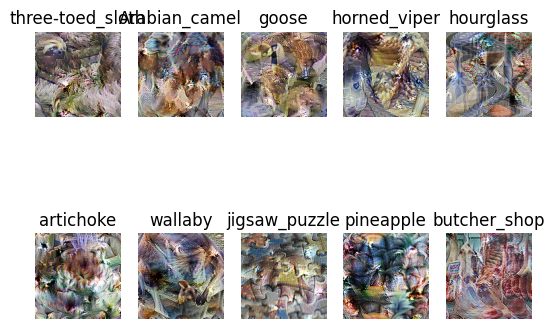

In [25]:
from src.analyzers.lucent_analyzer import get_topk_activating_images
import math

K = 10

top_image_indices, mean_values = get_topk_activating_images(model, lucent_images_dataset,
                                                            HUGGINGFACE_MODEL_DESCRIPTOR, 
                                                            K, device=device)

columns = 5
rows = math.ceil(K / columns)
for i, index in enumerate(top_image_indices.tolist()):

    ax = plt.subplot(rows, columns, i+1)
    entry = lucent_images_dataset[index]

    ax.set_title(entry['name'])
    ax.imshow(entry['img'])
    ax.axis('off')

plt.tight_layout()
plt.show()

In these $10$ most activating images, we can see a couple of animals, especially ones that appear to be unique from their looks in the dataset. The sloth for example is often displayed in a clear setting, hanging in a tree, with no related animals in the dataset that appear to do the same. Other classes, like the jigsaw puzzle, the pineapple, the artichoke hae a very clear pattern associated to them, which leads to the belief that objects that inhibit a clear pattern can be well predicted by the Vision Transformer. The horned viper is interesting in that regard, because it has a clear scale pattern associated to it. The butcher shop in contrast sticks out through its color, but once again some patters in the ribs of the butchered animals.  

### Qualitative Results

Now we come to the part where we investigate the images that were generated in [section 4](#4-Generating-Images). Specifically, we will compare and analyze these images in the following manner:
1. Look at the final version of each image optimized for a single value and what class information we can make out.
2. Look at the final version of each image optimized for mixed values, what class information we can make out.
3. Compare mixed and single value optimizations for good and bad classes.
4. Look at the development of mixed and single value optimizations from $167$ to $334$ to $500$ iterations.

We will start of with the final versions of all images optimized for a single value vector.

__NOTE__: Because of the output format of Lucent, we will first have to convert all images to the appropriate `PIL` format.

In [39]:
from typing import Dict

def prepare_images(images: Dict[str, List[np.ndarray]], is_div: bool):

    images_by_class = {}

    for cls in images.keys():
        images_for_class = {} # dictionary with iteration key and (list of) image values
        for iter_ind, iteration in enumerate(ITERATIONS):
            if is_div:
                images_for_class[str(iteration)] = []
                for i in range(DIVERSITY_BATCH_SIZE):
                    images_for_class[str(iteration)].append(
                        Image.fromarray((images[cls][iter_ind][i]*255).astype(np.uint8))
                    )
            else:
                images_for_class[str(iteration)] = Image.fromarray(
                    (images[cls][iter_ind][0]*255).astype(np.uint8)
                )
        images_by_class[cls] = images_for_class

    return images_by_class

# Map all the numpy images to PIL Images
good_images_single_value_prep = prepare_images(good_images_single_value, False)
good_images_single_value_div_prep = prepare_images(good_images_single_value_div, True)
bad_images_single_value_prep = prepare_images(bad_images_single_value, False)
bad_images_single_value_div_prep = prepare_images(bad_images_single_value_div, True)

good_images_multiple_values_prep = prepare_images(good_images_multiple_values, False)
good_images_multiple_values_div_prep = prepare_images(good_images_multiple_values_div, True)
bad_images_multiple_values_prep = prepare_images(bad_images_multiple_values, False)
bad_images_multiple_values_div_prep = prepare_images(bad_images_multiple_values_div, True)

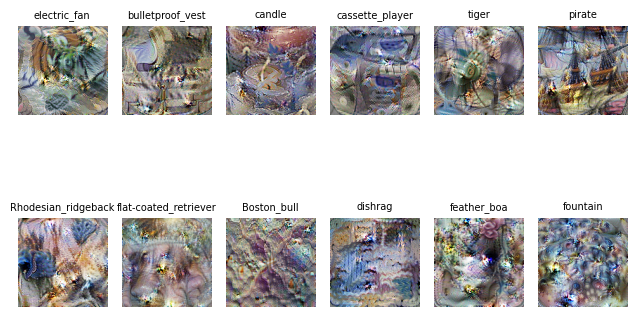

In [68]:
# Show single value non-diversity images
for i, cls in enumerate(good_images_single_value_prep.keys()):
    ax = plt.subplot(2, 6, i+1)
    ax.set_title(cls, fontsize=7)
    ax.imshow(good_images_single_value_prep[cls]['500'])
    ax.axis('off')

for i, cls in enumerate(bad_images_single_value_prep.keys()):
    ax = plt.subplot(2, 6, i+7)
    ax.set_title(cls, fontsize=7)
    ax.imshow(bad_images_single_value_prep[cls]['500'])
    ax.axis('off')

plt.tight_layout()
plt.show()

Above we can see the good classes in the first row and the bad classes in the second row. As expected, the bad classes contain non-interpretable results that offer almost no attributes one would associate with their classes. The good classes however, contain highly-interpretable results. The tiger shows its typical color pattern, the bulletproof vest 

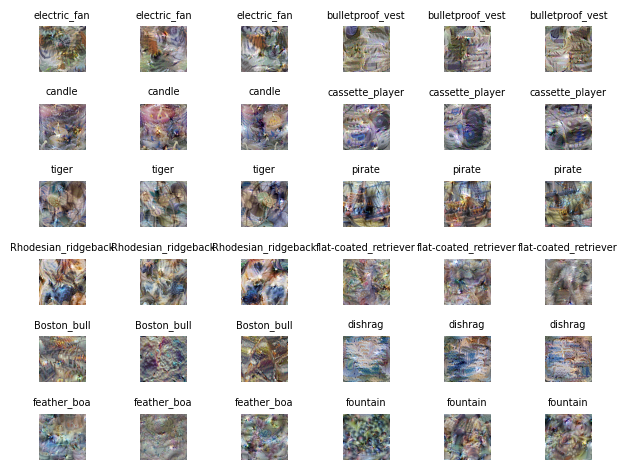

In [69]:
# Show single value diversity images
for i, cls in enumerate(good_images_single_value_div_prep.keys()):
    for ii in range(DIVERSITY_BATCH_SIZE):
        ax = plt.subplot(6, 6, ii+(i*DIVERSITY_BATCH_SIZE)+1)
        ax.set_title(cls, fontsize=7)
        ax.imshow(good_images_single_value_div_prep[cls]['500'][ii])
        ax.axis('off')

for i, cls in enumerate(bad_images_single_value_div_prep.keys()):
        for ii in range(DIVERSITY_BATCH_SIZE):
            ax = plt.subplot(6, 6, ii+(i*DIVERSITY_BATCH_SIZE)+19)
            ax.set_title(cls, fontsize=7)
            ax.imshow(bad_images_single_value_div_prep[cls]['500'][ii])
            ax.axis('off')

plt.tight_layout()
plt.show()

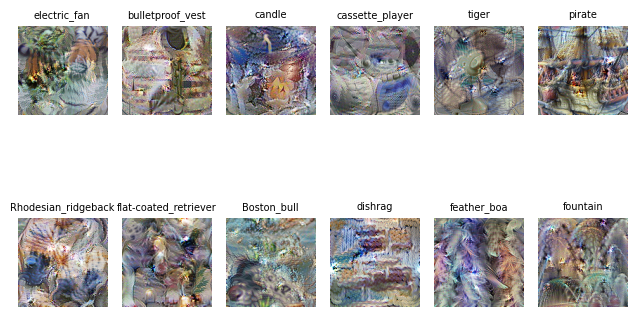

In [70]:
# Show multiple value non-diversity images
for i, cls in enumerate(good_images_multiple_values_prep.keys()):
    ax = plt.subplot(2, 6, i+1)
    ax.set_title(cls, fontsize=7)
    ax.imshow(good_images_multiple_values_prep[cls]['500'])
    ax.axis('off')

for i, cls in enumerate(bad_images_multiple_values_prep.keys()):
    ax = plt.subplot(2, 6, i+7)
    ax.set_title(cls, fontsize=7)
    ax.imshow(bad_images_multiple_values_prep[cls]['500'])
    ax.axis('off')

plt.tight_layout()
plt.show()

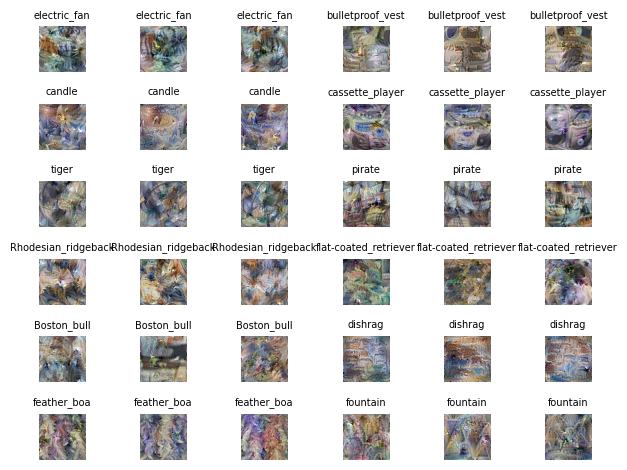

In [71]:
# Show multiple value diversity images
for i, cls in enumerate(good_images_multiple_values_div_prep.keys()):
    for ii in range(DIVERSITY_BATCH_SIZE):
        ax = plt.subplot(6, 6, ii+(i*DIVERSITY_BATCH_SIZE)+1)
        ax.set_title(cls, fontsize=7)
        ax.imshow(good_images_multiple_values_div_prep[cls]['500'][ii])
        ax.axis('off')

for i, cls in enumerate(bad_images_multiple_values_div_prep.keys()):
        for ii in range(DIVERSITY_BATCH_SIZE):
            ax = plt.subplot(6, 6, ii+(i*DIVERSITY_BATCH_SIZE)+19)
            ax.set_title(cls, fontsize=7)
            ax.imshow(bad_images_multiple_values_div_prep[cls]['500'][ii])
            ax.axis('off')

plt.tight_layout()
plt.show()

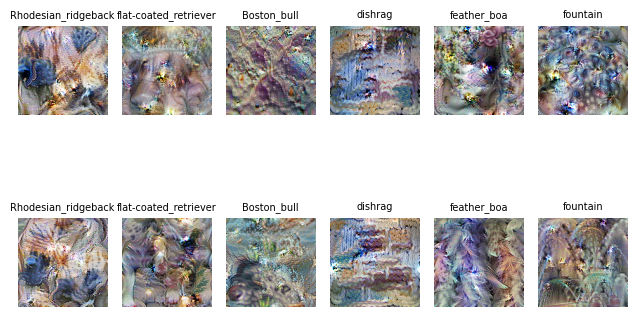

In [72]:
# Compare multiple and single value bad images
for i, cls in enumerate(bad_images_single_value_prep.keys()):
    ax = plt.subplot(2, 6, i+1)
    ax.set_title(cls, fontsize=7)
    ax.imshow(bad_images_single_value_prep[cls]['500'])
    ax.axis('off')

for i, cls in enumerate(bad_images_multiple_values_prep.keys()):
    ax = plt.subplot(2, 6, i+7)
    ax.set_title(cls, fontsize=7)
    ax.imshow(bad_images_multiple_values_prep[cls]['500'])
    ax.axis('off')

plt.tight_layout()
plt.show()

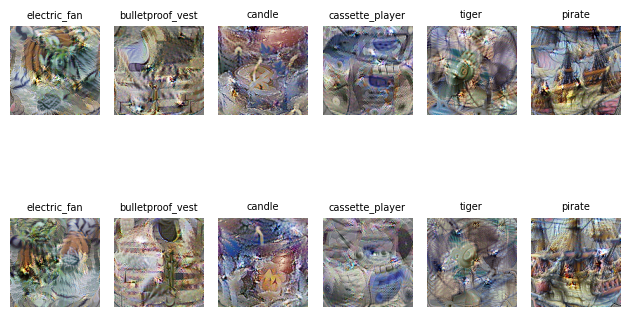

In [73]:
# Compare multiple and single value good images
for i, cls in enumerate(good_images_single_value_prep.keys()):
    ax = plt.subplot(2, 6, i+1)
    ax.set_title(cls, fontsize=7)
    ax.imshow(good_images_single_value_prep[cls]['500'])
    ax.axis('off')

for i, cls in enumerate(good_images_multiple_values_prep.keys()):
    ax = plt.subplot(2, 6, i+7)
    ax.set_title(cls, fontsize=7)
    ax.imshow(good_images_multiple_values_prep[cls]['500'])
    ax.axis('off')

plt.tight_layout()
plt.show()

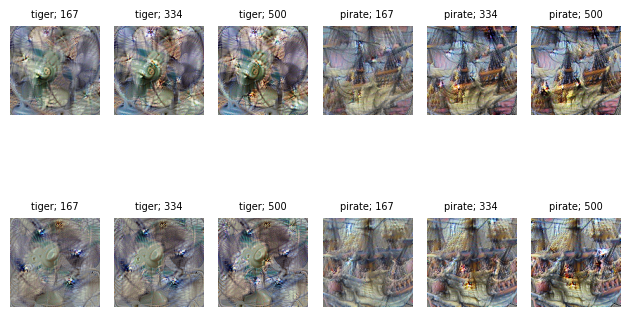

In [77]:
# Compare mixed and single good images over time
for i, cls in enumerate(good_classes[-2:]):
    for ii, iteration in enumerate(ITERATIONS):
        ax = plt.subplot(2, 6, (i*3)+ii+1)
        ax.set_title(f'{cls}; {iteration}', fontsize=7)
        ax.imshow(good_images_single_value_prep[cls][str(iteration)])
        ax.axis('off')

for i, cls in enumerate(good_classes[-2:]):
    for ii, iteration in enumerate(ITERATIONS):
        ax = plt.subplot(2, 6, (i*3)+ii+7)
        ax.set_title(f'{cls}; {iteration}', fontsize=7)
        ax.imshow(good_images_multiple_values_prep[cls][str(iteration)])
        ax.axis('off')

plt.tight_layout()
plt.show()

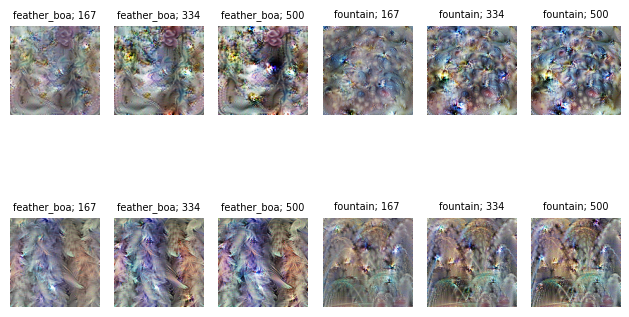

In [78]:
# Compare mixed and single bad images over time
for i, cls in enumerate(bad_classes[-2:]):
    for ii, iteration in enumerate(ITERATIONS):
        ax = plt.subplot(2, 6, (i*3)+ii+1)
        ax.set_title(f'{cls}; {iteration}', fontsize=7)
        ax.imshow(bad_images_single_value_prep[cls][str(iteration)])
        ax.axis('off')

for i, cls in enumerate(bad_classes[-2:]):
    for ii, iteration in enumerate(ITERATIONS):
        ax = plt.subplot(2, 6, (i*3)+ii+7)
        ax.set_title(f'{cls}; {iteration}', fontsize=7)
        ax.imshow(bad_images_multiple_values_prep[cls][str(iteration)])
        ax.axis('off')

plt.tight_layout()
plt.show()